In [53]:
%load_ext autoreload
%autoreload 2

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import io
from tqdm import tqdm
import re


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from misc.utils import get_dict_item, read_lines

In [55]:
def get_data(filter = '', logdir = '../logs', net = 'FNO1d'):
    version_dirs = glob.glob(os.path.join(logdir, net, '*/'))

    data = {'_'.join(os.path.normpath(version_dir).split('/')[-2:]) : {'dir' : version_dir} for version_dir in version_dirs}

    # fitler data.keys() on regex
    pattern = re.compile(filter)
    for key in list(data.keys()):
        if not pattern.search(key):
            data.pop(key)

    return data

In [109]:
def get_results(version_dir, split = 'val'):

    val_loss = []
    val_plot = []
    test_loss = []

    for filename in os.listdir(version_dir):

        if 'events.out.tfevents' in filename:

            file_path = os.path.join(version_dir, filename)
            raw_dataset = tf.data.TFRecordDataset(file_path)

            try:
                for raw_record in raw_dataset:
                    event = tf.compat.v1.Event.FromString(raw_record.numpy())
                    for v in event.summary.value:
                        if v.tag == f'val_loss':
                            val_loss.append(v.simple_value)

                        # if v.tag == f'val_plot':
                        #     image_enc = v.image.encoded_image_string
                        #     image = Image.open(io.BytesIO(image_enc))
                        #     val_plot.append(image)

                        if v.tag == f'test_loss':
                            test_loss.append(v.simple_value)
            except:
                continue

    
    val_loss = np.array(val_loss)
    test_loss = np.array(test_loss)
    return val_loss, val_plot, test_loss

def get_color(version):
    if 'aug0' in version:
        return 'tab:blue'
    elif 'aug1' in version:
        return 'tab:orange'
    else:
        return 'tab:green'

In [57]:
def get_metrics(data):
    for version, version_dict in tqdm(data.items()):
        version_dict['val_loss'], version_dict['val_plot'], version_dict['test_loss'] = get_results(version_dict['dir'])
        version_dict['color'] = get_color(version)
    return data

In [58]:
def plot_testloss(data, print_loss = False):
    plt.style.use('default')

    test_loss_noaug = np.array([v['test_loss'][0] for k, v in data.items() if 'aug0' in k and len(v['test_loss']) > 0]).flatten()
    test_loss_aug   = np.array([v['test_loss'][0] for k, v in data.items() if 'aug1' in k and len(v['test_loss']) > 0]).flatten()

    if print_loss:
        print('No Aug: ', test_loss_noaug)
        print('Aug:    ', test_loss_aug)

    plt.figure(figsize=(3,4))
    bins = None
    plt.hist(test_loss_noaug, label='No Aug', alpha = 0.5, bins = bins, color = 'tab:blue')
    # _, bins, _ = plt.hist(test_loss_noaug, label='No Aug', alpha = 0.5, bins = bins, color = 'tab:blue')
    plt.hist(test_loss_aug, label='Aug', alpha = 0.5, bins = bins, color = 'tab:orange')
    plt.legend()
    plt.show()

In [59]:
def parse_arguments_to_dict(arg_list):
    """
    Parses a list of argument strings into a list of dictionaries.

    Each string in the list is expected to have a format like '--key value',
    and this function will convert these strings into dictionaries where
    each key-value pair is an entry.

    :param arg_list: List of argument strings.
    :return: List of dictionaries with parsed key-value pairs.
    """
    parsed_list = []

    for arg_str in arg_list:
        # Split the string into individual arguments
        args = arg_str.strip().split('--')
        args_dict = {}

        for arg in args:
            if arg:
                # Split each argument into key and value
                key, value = arg.strip().split(maxsplit=1)
                args_dict[key] = value

        parsed_list.append(args_dict)

    return parsed_list

In [60]:
# hparams = read_lines('../jobs/array_train_hparams.txt')
# hparams = parse_arguments_to_dict(hparams)
# hparams

In [61]:
# for hparam in hparams:
#     filter = f"optim{hparam['optimizer']}_lr{float(hparam['lr'])}_scheduler{hparam['scheduler']}"

#     print(filter)
#     data = get_data(filter = filter)
#     data = get_metrics(data)
#     plot_testloss(data, print_loss = True)

In [104]:
data = get_data(filter = 'precision_datasympde_aug.*_pde1')

In [111]:
data = get_metrics(data)

100%|██████████| 10/10 [01:33<00:00,  9.34s/it]


No Aug:  [0.00793432 0.01152956 0.00905237 0.01135712 0.01070987]
Aug:     [0.00782025 0.00671147 0.01035725 0.01674113 0.00528927]


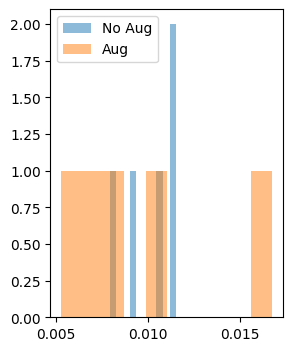

In [116]:
plot_testloss(data, print_loss = True)

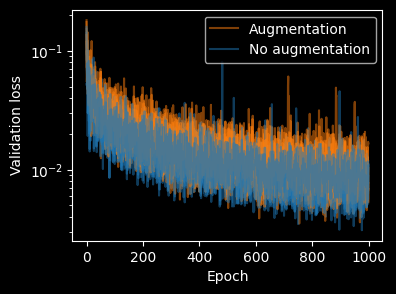

In [113]:
plt.style.use('dark_background')


fig, axs = plt.subplots(1, 1, figsize=(4, 3))
for version, version_dict in data.items():

    if version[-1] ==  get_dict_item(data)[0][-1]:  # only one version needed for label
        if 'aug1' in version:
            label = 'Augmentation'
        elif 'aug0' in version:
            label = 'No augmentation'
    else:
        label = ''

    axs.plot(version_dict['val_loss'], label=label, color=version_dict['color'], alpha = 0.5)
axs.set_xlabel('Epoch')
axs.set_ylabel('Validation loss')
axs.set_yscale('log')
axs.legend()
plt.show()

In [126]:
n_iterations = get_dict_item(data)[1]['val_loss'].shape[0]
val_losses = np.full((2, len(data)//2, n_iterations), np.nan)
test_losses = np.full((2, len(data)//2, 1), np.nan)
print(val_losses.shape)

(2, 5, 1000)


In [127]:
for version, version_dict in data.items():
    i_aug = 0 if 'aug0' in version else 1
    seed = int(version[-1])-1
    val_losses[i_aug, seed] = version_dict['val_loss']
    test_losses[i_aug, seed] = version_dict['test_loss']

assert np.isnan(val_losses).sum() == 0


In [134]:
means, stds = np.mean(test_losses, axis = 1).reshape(-1), np.std(test_losses, axis = 1).reshape(-1)
for mean, std in zip(means, stds):
    print(f"{mean:.4f} ± {std:.4f}")

0.0101 ± 0.0014
0.0094 ± 0.0040


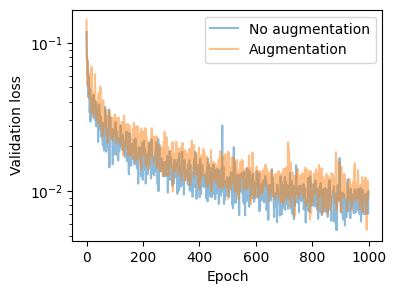

In [118]:
colors = ['tab:blue', 'tab:orange']
labels = ['No augmentation', 'Augmentation']


fig, ax = plt.subplots(1, 1, figsize=(4, 3))

for i, val_loss_aug in enumerate(val_losses):
    mean = val_loss_aug.mean(axis = 0)
    std = val_loss_aug.std(axis = 0)

    ax.plot(mean, color = colors[i], label = labels[i], alpha = 0.5)
    # ax.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha = 0.5, color = colors[i])

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.set_yscale('log')
ax.legend()
plt.show()

### More plots

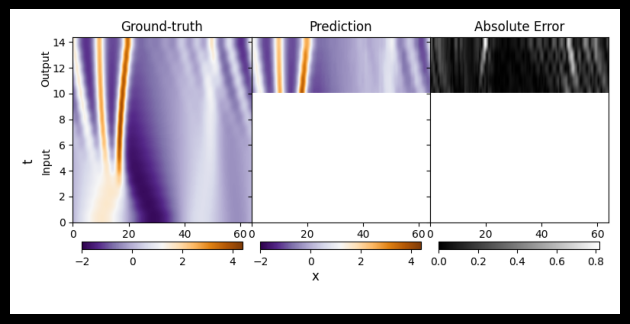

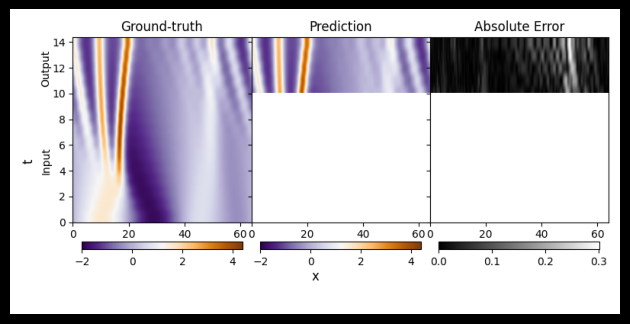

In [101]:
keys = ['FNO1d_precision_datasympde_aug0_KdV_seed4', 'FNO1d_precision_datasympde_aug1_KdV_seed4']
for key in keys:
    images = data[key]['val_plot']
    im = images[-1]
    plt.figure(tight_layout=True)
    plt.imshow(im)
    plt.axis('off')
    plt.show()